In [1]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from autocluster.autohypothesis import autohypothesis_utils

In [2]:
sk_iris = datasets.load_iris()
iris = pd.DataFrame(sk_iris['data'], columns=sk_iris['feature_names'])
iris['target'] = sk_iris['target']


In [3]:
exp,X_train, X_dev, y_train, y_dev  = autohypothesis_utils.opti_loop(iris,500, optimize_obj="dual")


[I 2024-04-23 14:36:36,830] A new study created in memory with name: no-name-8d427b86-85de-4b92-aec7-11e519666680
[I 2024-04-23 14:36:37,103] Trial 0 finished with values: [0.6666666666666666, 0.35084957676602724] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 360, 'rf_max_depth': 27, 'rf_min_samples_split': 0.35983677040019263, 'rf_min_samples_leaf': 0.32760135062239415, 'rf_max_features': 'log2', 'rf_random_state': 42}. 
[I 2024-04-23 14:36:37,291] Trial 1 finished with values: [0.3333333333333333, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 250, 'rf_max_depth': 27, 'rf_min_samples_split': 0.4678273931508071, 'rf_min_samples_leaf': 0.4458526603199738, 'rf_max_features': 'log2', 'rf_random_state': 42}. 
[I 2024-04-23 14:36:37,933] Trial 2 finished with values: [0.9777777777777777, 0.25985840964181317] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 850, 'rf_max_depth': 14, 'rf_min_samples_split': 0.624995948492011, 'rf_mi

In [4]:
fig = optuna.visualization.plot_pareto_front(exp, target_names=["Accuracy", "Entropie"], include_dominated_trials=False)
#fig = optuna.visualization.plot_pareto_front(motpe_experiment, target_names=["objective 1", "objective 2"])
fig.layout.title = 'Pareto-front MOTPE'
fig

In [5]:
all_objectives = np.array([trial.values for trial in exp.best_trials ])
#all_objectives = np.unique(all_objectives, axis=0)
sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
all_objectives

array([[0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.93333333, 0.51902191],
       [0.66666667, 1.        ],
       [0.66666667, 1.        ],
       [0.73333333, 0.605711  ],
       [0.

In [6]:
exp.best_trials

[FrozenTrial(number=73, state=TrialState.COMPLETE, values=[0.9333333333333333, 0.5190219073493036], datetime_start=datetime.datetime(2024, 4, 23, 14, 37, 3, 843664), datetime_complete=datetime.datetime(2024, 4, 23, 14, 37, 4, 223664), params={'classifier': 'RandomForest', 'rf_n_estimators': 480, 'rf_max_depth': 11, 'rf_min_samples_split': 0.6866471085513467, 'rf_min_samples_leaf': 0.06756596768702872, 'rf_max_features': 'sqrt', 'rf_random_state': 42}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'rf_n_estimators': IntDistribution(high=1000, log=False, low=10, step=10), 'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_min_samples_split': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'rf_min_samples_leaf': FloatDistribution(high=0.5, log=False, low=0.01, step=None), 'rf_max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'rf_random_state': IntDis

In [7]:
data = []
for trial in exp.best_trials:
    # Ici, on suppose que `values` contient [accuracy, entropy] dans cet ordre
    accuracy, entropy = (round(val, 3) for val in trial.values) if trial.values else (None, None)
    data.append({
        'number': trial.number,
        'accuracy': accuracy,
        'entropy': 1-entropy,
        'params': trial.params
    })

# Convertir la liste de dictionnaires en un DataFrame
df = pd.DataFrame(data)
df.to_csv("opti_duo_500_iris.csv")

In [8]:
params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=10) #61 #126
pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
pipeline.fit(X_train, y_train)
acc = accuracy_score(y_dev, pipeline.predict(X_dev))
entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
print(f"Accuracy: {acc:.4f} - Entropy: {1-entropy:.4f}")

Accuracy: 0.8667 - Entropy: 0.7632


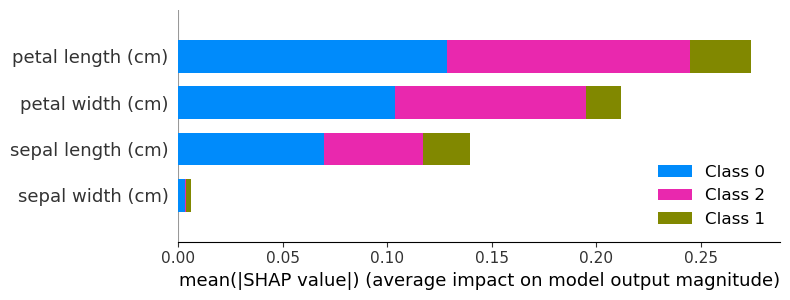

In [9]:
import shap

# Initialize your explainer
explainer = shap.Explainer(pipeline.named_steps['classifier'])

# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [10]:
vect = np.mean(np.abs(shap_values[1]), axis=0) 
I_c_minmax = (vect - np.min(vect)) / (np.max(vect) - np.min(vect))
sum_I_c_minmax = np.sum(I_c_minmax)
I_c_normalized = I_c_minmax / sum_I_c_minmax

In [11]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 17, 1: 39, 2: 34}


In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


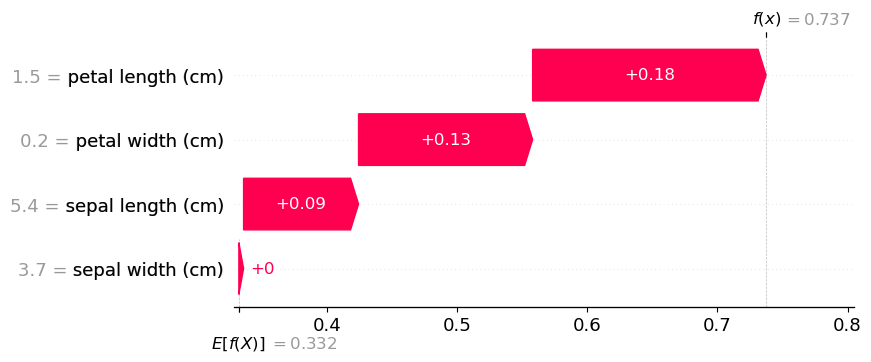

In [13]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [14]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

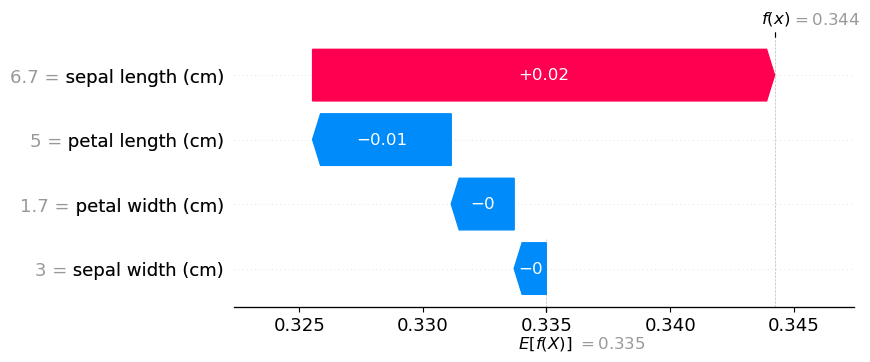

In [15]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

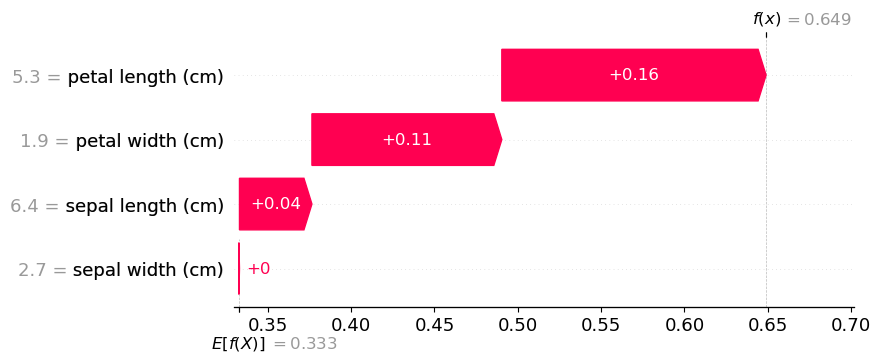

In [17]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row],
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))